# Parallel computing with Dask

## Authors & Contributors
### Authors
- Tina Odaka, Ifremer (France), [@tinaok](https://github.com/tinaok)
- Pier Lorenzo Marasco, Ispra (Italy), [@pl-marasco](https://github.com/pl-marasco)

### Contributors
- Anne Fouilloux, University of Oslo (Norway), [@annefou](https://github.com/annefou)
- Guillaume Eynard-Bontemps, CNES (France), [@guillaumeeb](https://github.com/guillaumeeb)


<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> Overview
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>What is Dask?</li>
        <li>How can I parallelize my data analysis with Dask?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about Dask</li>
        <li>Learn about Dask Gateway, Dask Client, Scheduler, Workers</li>
        <li>Understand out-of-core and speed-up limitations</li>
    </ul>
</div>

## Context


We will be using [Dask](https://docs.dask.org/) with [Xarray](https://docs.xarray.dev/en/stable/) to parallelize our data analysis. The analysis is very similar to what we have done in previous episodes but this time we will use data on a global coverage that we read from a shared catalog (stored online in the Pangeo EOSC Openstack Object Storage).

### Data

In this episode, we will be using Global Long Term Statistics (1999-2019) product provided by the [Copernicus Global Land Service over Lombardia](https://land.copernicus.eu/global/index.html) and access them through [S3-comptabile storage](https://en.wikipedia.org/wiki/Amazon_S3) ([OpenStack Object Storage "Swift"](https://wiki.openstack.org/wiki/Swift)) with a data catalog we have created and made publicly available.

## Setup

This episode uses the following Python packages:

- pooch {cite:ps}`e-pooch-Uieda2020`
- s3fs {cite:ps}`e-s3fs-2016`
- xarray {cite:ps}`e-xarray-hoyer2017` with [`netCDF4`](https://pypi.org/project/h5netcdf/) and [`h5netcdf`](https://pypi.org/project/h5netcdf/) engines
- hvplot {cite:ps}`e-holoviews-rudiger2020`
- dask {cite:ps}`e-dask-2016`
- graphviz {cite:ps}`e-graphviz-Ellson2003`
- numpy {cite:ps}`e-numpy-harris2020`
- pandas {cite:ps}`e-pandas-reback2020`
- geopandas {cite:ps}`e-geopandas-jordahl2020`

Please install these packages if not already available in your Python environment (you might want to take a look at [the Setup page of the tutorial](https://pangeo-data.github.io/foss4g-2022/before/setup.html)).
### Packages

In this episode, Python packages are imported when we start to use them. However, for best software practices, we recommend you to install and import all the necessary libraries at the top of your Jupyter notebook.

## Parallelize with Dask

We know from previous chapter [chunking_introduction](./chunking_introduction.ipynb) that chunking is key for analyzing large datasets. In this episode, we will learn to parallelize our data analysis using [Dask](https://docs.dask.org/) on our chunked dataset. 

### What is [Dask](https://docs.dask.org/) ?

**Dask** scales the existing Python ecosystem: with very or no changes in your code, you can speed-up computation using Dask or process bigger than memory datasets.

- Dask is a flexible library for parallel computing in Python.
- It is widely used for handling large and complex Earth Science datasets and speed up science.
- Dask is powerful, scalable and flexible. It is the leading platform today for data analytics at scale.
- It scales natively to clusters, cloud, HPC and bridges prototyping up to production.
- The strength of Dask is that is scales and accelerates the existing Python ecosystem e.g. Numpy, Pandas and Scikit-learn with few effort from end-users.

It is interesting to note that at first, [Dask has been created to handle data that is larger than memory, on a single computer](https://coiled.io/blog/history-dask/). It then was extended with Distributed to compute data in parallel over clusters of computers.

#### How does Dask scale and accelerate your data analysis?

[Dask proposes different abstractions to distribute your computation](https://docs.dask.org/en/stable/10-minutes-to-dask.html). In this _Dask Introduction_ section, we will focus on [Dask Array](https://docs.dask.org/en/stable/array.html) which is widely used in pangeo ecosystem as a back end of Xarray.

As shown in the [previous section](./chunking_introduction.ipynb) Dask Array is based on chunks.
Chunks of a Dask Array are well-known Numpy arrays. By transforming our big datasets to Dask Array, making use of chunk, a large array is handled as many smaller Numpy ones and we can compute each of these chunks independently.

![Dask and Numpy](https://examples.dask.org/_images/dask-array-black-text.svg)



<div class="alert alert-info">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Warning</b>
    <br>
    <ul>
        <li>`Xarray` uses Dask Arrays instead of Numpy when chunking is enabled, and thus all Xarray operations are performed through Dask, which enables distributed processing. </li>
    </ul>
</div>


#### How does Xarray with Dask distribute data analysis?

When we use chunks with `Xarray`, the real computation is only done when needed or asked for, usually when invoking `compute()` function. Dask generates a **task graph** describing the computations to be done. When using [Dask Distributed](https://distributed.dask.org/en/stable/) a **Scheduler** distributes these tasks across several **Workers**.

![Xarray with dask](../figures/dask-xarray-explained.png)

#### What is a Dask Distributed ?

A Dask Distributed is made of two main components:

- a Scheduler, responsible for dishandling computations graph and distributing tasks to Workers.
- One or several (up to 1000s) Workers, computing individual tasks and storing results and data into distributed memory (RAM and/or worker's local disk).

Dask Distributed use two objects, distributed __Client__ and __Cluster__ as shown below.    

![Dask Distributed Cluster](https://user-images.githubusercontent.com/306380/66413985-27111600-e9be-11e9-9995-8f418ff48f8a.png)

#### Where can we deploy Dask distributed cluster?  
[Dask distributed clusters can be deployed on your laptop or on distributed infrastructures ( Cloud, HPC centers or ..).](https://docs.dask.org/en/stable/deploying.html)  Dask distributed `Cluster` object is responsible of deploying and scaling a Dask Cluster on the underlying resources.

![Dask Cluster deployment](https://docs.dask.org/en/stable/_images/dask-cluster-manager.svg)

:::{tip}
A Dask `Cluster` can also be created on a single machine (for instance your laptop) e.g. there is no need to have dedicated computational resources. However, speedup will only be limited to your single machine resources if you do not have dedicated computational resources!
:::

### Dask distributed Client
 
The Dask distributed `Client` is what allows you to interact with Dask distributed Clusters. When using Dask distributed, you always need to create a `Client` object. Once a `Client` has been created, it will be used by default by each call to a Dask API, even if you do not explicitly use it.

No matter the Dask API (e.g. Arrays, Dataframes, Delayed, Futures, etc.) that you use, under the hood, Dask will create a Directed Acyclic Graph (DAG) of tasks by analysing the code. Client will be responsible to submit this DAG to the Scheduler along with the final result you want to compute. The Client will also gather results from the Workers, and aggregates it back in its underlying Python process.

Using `Client()` function with no argument, you will create a local Dask cluster with a number of workers and threads per worker corresponding to the number of cores in the 'local' machine. Here, during the workshop, we are running this notebook in Pangeo EOSC cloud deployment, so the 'local' machine is the jupyterlab you are using at the Cloud, and the number of cores is the number of cores on the cloud computing resources you've been given (not on your laptop).

In [1]:
from dask.distributed import Client

client = Client()   # create a local dask cluster on the local machine.
client


2022-08-22 16:35:19,268 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-q5j0yto8', purging
2022-08-22 16:35:19,269 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-7p1fnhc_', purging


<Client: 'tcp://127.0.0.1:46523' processes=4 threads=4, memory=8.00 GiB>

Inspecting the `Cluster Info` section above gives us information about the created cluster: we have 2 or 4 workers and the same number of threads (e.g. 1 thread per worker). 



<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Go further</b>
    <br>
    <ul>
        <li> You can also create a local cluster with the `LocalCluster` constructor and use `n_workers` 
        and `threads_per_worker` to manually specify the number of processes and threads you want to use. 
        For instance, we could use `n_workers=2` and `threads_per_worker=2`.  </li>
        <li> This is sometimes preferable (in terms of performance), or when you run this tutorial on your PC, 
        you can avoid dask to use all your resources you have on your PC!  </li>
    </ul>
</div>

### Dask Dashboard

Dask comes with a really handy interface: the Dask Dashboard.
We will learn here, how to use that through [dask jupyterlab extension](https://github.com/dask/dask-labextension).  

To use Dask Dashbord through jupyterlab extension at Pangeo EOSC FOSS4G infrastructure,
you will just need too look at the html link you have for your jupyterlab, and Dask dashboard port number, as highlighted in the figure below.


<img src="../figures/dashboardlink.png" width="50%">
<img src="../figures/dasklab.png" width="30%">

Then click the orange icon indicated in the above figure, and type 'your' dashboard link (normally, you just need to replace 'todaka' to 'your username').  






You can click several buttons indicated with blue arrows in above figures, then drag and drop to place them as your convenience.  


<img src="../figures/exampledasklab.png" width="50%">


It's really helpfull to understand your computation and how it is distributed.

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Go Further</b>
    <br>
    <ul>
        <li>You have many example of Dask on this web site.  For example you can compute Pi </li>        
    </ul>
</div>

## Dask Distributed computations on our dataset

Lets open dataset from catalogue we made before, select a single location over time and visualize the task graph generated by Dask, and observe the Dask Dashboard.


In [13]:
import xarray as xr

catalogue="https://object-store.cloud.muni.cz/swift/v1/foss4g-catalogue/c_gls_NDVI-LTS_1999-2019.json"
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":catalogue
                    },
        "consolidated": False
    }
)
LTS

<xarray.Dataset>
Dimensions:  (lat: 15680, lon: 40320, time: 36)
Coordinates:
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) float64 nan 1.0 2.0 3.0 4.0 5.0 ... 31.0 32.0 33.0 34.0 35.0
Data variables:
    crs      object ...
    max      (time, lat, lon) float32 dask.array<chunksize=(36, 1207, 3102), meta=np.ndarray>
    mean     (time, lat, lon) float32 dask.array<chunksize=(36, 1207, 3102), meta=np.ndarray>
    median   (time, lat, lon) float32 dask.array<chunksize=(36, 1207, 3102), meta=np.ndarray>
    min      (time, lat, lon) float32 dask.array<chunksize=(36, 1207, 3102), meta=np.ndarray>
    nobs     (time, lat, lon) float32 dask.array<chunksize=(36, 1207, 3102), meta=np.ndarray>
    stdev    (time, lat, lon) float32 dask.array<chunksize=(36, 1207, 3102), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

By inspecting any of the variable on the representation above, you'll see that each data array represent __about 85GiB of data__, so much more thant what is available on this notebook server, and even on the Dask Cluster we created above. But thants to chunking, we can still analyze it!

In [14]:
save=LTS.sel(lat=45.50, lon=9.36, method='nearest')['min'].mean()
save.data


dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.903543 to fit


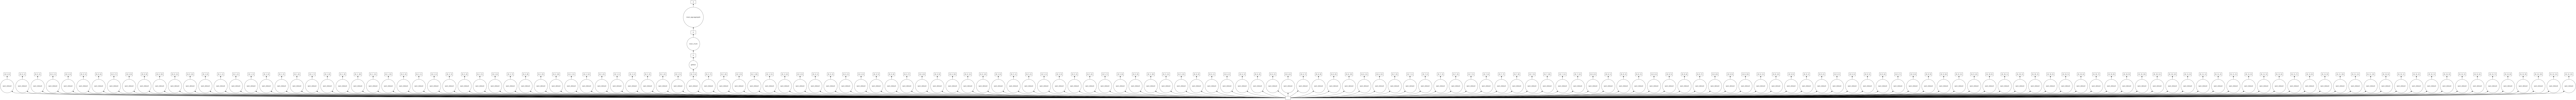

In [15]:
save.data.visualize()

Did you notice something on the Dask Dashboard when running the two previous cells?

We didn't 'compute' anything (we just build a Dask task graph with count indicated), but did not ask Dask to return a result.

But 'task count' we see more than 6000 task for just for computing a mean on 36 temporal steps. Which is too much.  If you have such case, to avoid unecessary operations, we can optimize the task graph using `dask.optimize`.  In general, this 'optimisation' is not necessary 

Lets try to plot the dask graph before computation and understand what dask workers will do to compute the value we asked for.  

### Optimize the task graph

In [16]:
import dask
(save,) = dask.optimize(save)
save.data

dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

Now our task is reduced to about 100. Lets try to visualise it:

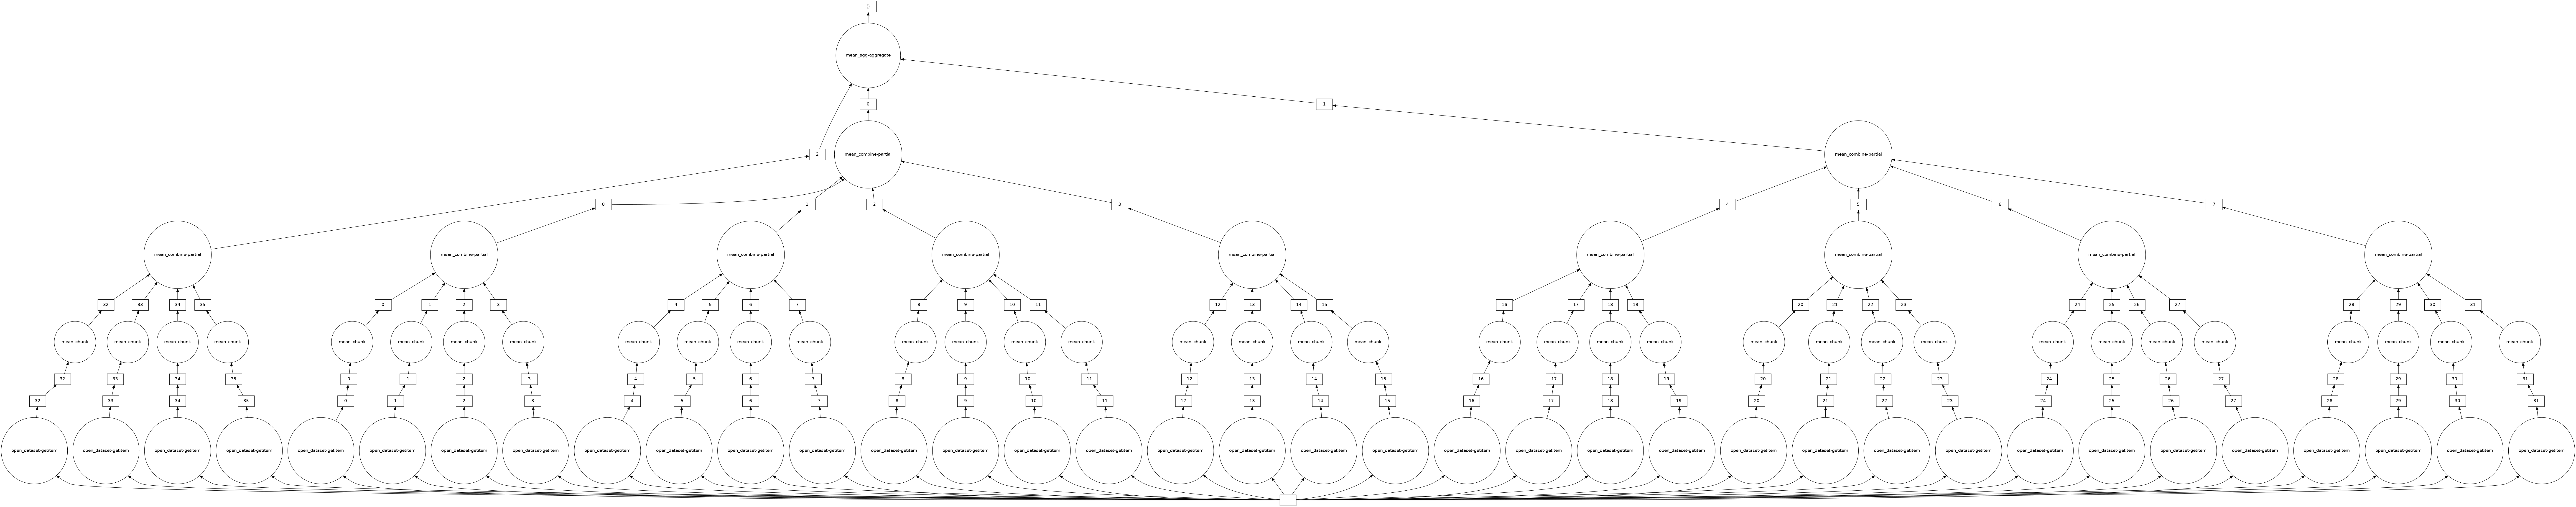

In [5]:
save.data.visualize()

### Compute on the dask workers

In [6]:
save.compute()

<xarray.DataArray 'min' ()>
array(0.31844446, dtype=float32)
Coordinates:
    lat      float64 45.5
    lon      float64 9.357

Calling compute on our Xarray object triggered the execution on Dask Cluster side. 

You should be able to see how Dask is working on Dask Dashboard. 

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Go Further</b>
    <br>
    <ul>
        <li>You can re-open the LTS with ,chunks=({"time":-1}) option, and try to visualize the task graphe again.  What do you see?  How did it changed?  Do you see the difference of task graphe using chunk at the opening? </li>        
    </ul>
</div>


### Close client to terminate local dask cluster

The `Client` and associated `LocalCluster` object will be automatically closed when your Python session ends. When using Jupyter notebooks, we recommend to close it explicitely whenever you are done with your local Dask cluster.

In [18]:
client.close()

## Scaling your Computation using Dask Gateway.

For this workshop, according to the Pangeo EOSC deployment, you will learn how to use Dask Gateway to manage Dask clusters over Kubernetes, allowing to run our data analysis in parallel e.g. distribute tasks across several workers.

Lets set up your Dask Gateway.  
As Dask Gateway is configured by default on this ifnrastructure, you just need to execute the following cells.

In [19]:
from dask_gateway import Gateway
gateway = Gateway()

### Create a new Dask cluster with the Dask Gateway

In [9]:
cluster = gateway.new_cluster()
cluster.scale(4)
cluster

Lets setup the Dask Dashboard with your new cluster.  

### Get a client from the Dask Gateway Cluster

As stated above, creating a Dask `Client` is mandatory in order to perform following Daks computations on your Dask Cluster.

In [ ]:
## Please don't execute this cell, it is needed for building the Jupyter Book
cluster = None

In [10]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

<Client: 'tls://10.244.7.7:8786' processes=4 threads=4, memory=8.00 GiB>

## Global LTS computation

In the previous episode, we used Long-term Timeseries for the region of Lombardy e.g. a very small area that was extracted upfront for simplicity. Now we will use the original dataset that has a global coverage, and work directly on it to extract our AOI and perform computations.

### Read from online kerchunked consolidated dataset

 We will access Long Term TimeSeries of NDVI statistics from OpenStack Object Storage using the Zarr metadata generated with kerchunk, prepared in [previous chunking_introduction](./chunking_introduction.ipynb) section.

In [11]:
import pandas as pd
import numpy as np

### Visualize LTS statistics

Don't forget to have a look at the Dashboard when executing the cells below.

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'LTS NDVI statistics (Minimum and Maximum)')

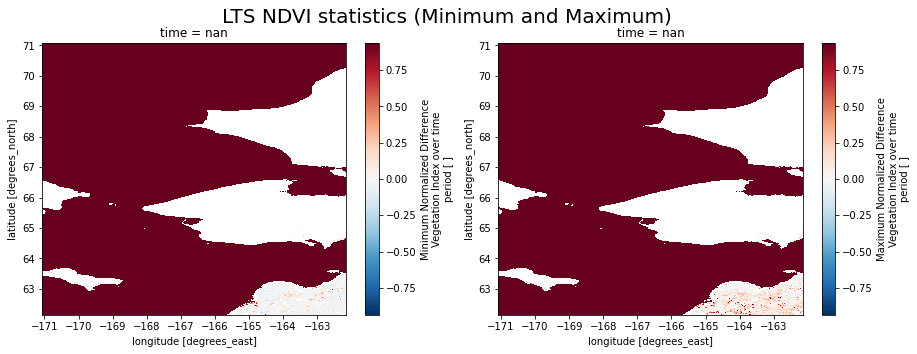

In [13]:
fig = plt.figure(1, figsize=[15,5])

# Fix extent
minval = 0.0
maxval = 0.9

itime=0 # plot the first date

# Plot 1 for min subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1)
LTS.isel(time=itime, lat=slice(1000,2000), lon=slice(1000,2000))['min'].plot(ax=ax1)
# Plot 2 for max
# 2nd plot
ax2 = plt.subplot(1, 2, 2)
LTS.isel(time=itime, lat=slice(1000,2000), lon=slice(1000,2000))['max'].plot(ax=ax2)

# Title for both plots
fig.suptitle('LTS NDVI statistics (Minimum and Maximum)', fontsize=20)

### Fix time coordinate

As observed data are coming with a predefined year. To let xarray automatically align the LTS with the lastest NDVI values, the time dimension needs to be shifted to the NDVI values.

In [14]:
dates_2022 = pd.date_range('20220101', '20221231')
time_list = dates_2022[np.isin(dates_2022.day, [1,11,21])]

In [15]:
LTS = LTS.assign_coords(time=time_list)
LTS

<xarray.Dataset>
Dimensions:  (lat: 15680, lon: 40320, time: 36)
Coordinates:
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
Data variables:
    crs      object ...
    max      (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    mean     (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    median   (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    min      (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    nobs     (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    stdev    (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

### Clip LTS over Lombardia
As in previous episodes, we use a shapefile over Italy to select data over this Area of Interest (AOI).

In [16]:
import geopandas as gpd

In [17]:
try:
    GAUL = gpd.read_file('Italy.geojson')
except:
    GAUL = gpd.read_file('zip+https://mars.jrc.ec.europa.eu/asap/files/gaul1_asap.zip') 

In [18]:
AOI_name = 'Lombardia'
AOI = GAUL[GAUL.name1 == AOI_name]
AOI_poly = AOI.geometry
AOI_poly

14    POLYGON ((10.23973 46.62177, 10.25084 46.61110...
Name: geometry, dtype: geometry

We first select a geographical area that covers Lombardia (so that we have a first reduction from the global coverage) and then clip using the shapefile to avoid useless pixels.

In [19]:
LTS = LTS.sel(lat=slice(46.5,44.5), lon=slice(8.5,11.5))
LTS.rio.write_crs(4326, inplace=True)

<xarray.Dataset>
Dimensions:  (lat: 224, lon: 336, time: 36)
Coordinates:
    crs      int64 0
  * lat      (lat) float64 46.49 46.48 46.47 46.46 ... 44.53 44.52 44.51 44.5
  * lon      (lon) float64 8.5 8.509 8.518 8.527 ... 11.46 11.47 11.48 11.49
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
Data variables:
    max      (time, lat, lon) float32 dask.array<chunksize=(1, 224, 336), meta=np.ndarray>
    mean     (time, lat, lon) float32 dask.array<chunksize=(1, 224, 336), meta=np.ndarray>
    median   (time, lat, lon) float32 dask.array<chunksize=(1, 224, 336), meta=np.ndarray>
    min      (time, lat, lon) float32 dask.array<chunksize=(1, 224, 336), meta=np.ndarray>
    nobs     (time, lat, lon) float32 dask.array<chunksize=(1, 224, 336), meta=np.ndarray>
    stdev    (time, lat, lon) float32 dask.array<chunksize=(1, 224, 336), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

In [20]:
LTS = LTS.rio.clip(AOI_poly, crs=4326)

In [21]:
LTS

<xarray.Dataset>
Dimensions:  (lat: 203, lon: 327, time: 36)
Coordinates:
  * lat      (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.71 44.7 44.69
  * lon      (lon) float64 8.509 8.518 8.527 8.536 ... 11.39 11.4 11.41 11.42
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
    crs      int64 0
Data variables:
    max      (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    mean     (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    median   (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    min      (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    nobs     (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    stdev    (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

In [22]:
%%time
LTS.compute()

CPU times: user 448 ms, sys: 106 ms, total: 554 ms
Wall time: 5.08 s


<xarray.Dataset>
Dimensions:  (lat: 203, lon: 327, time: 36)
Coordinates:
  * lat      (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.71 44.7 44.69
  * lon      (lon) float64 8.509 8.518 8.527 8.536 ... 11.39 11.4 11.41 11.42
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
    crs      int64 0
Data variables:
    max      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    mean     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    median   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    min      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    nobs     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    stdev    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

In [23]:
LTS

<xarray.Dataset>
Dimensions:  (lat: 203, lon: 327, time: 36)
Coordinates:
  * lat      (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.71 44.7 44.69
  * lon      (lon) float64 8.509 8.518 8.527 8.536 ... 11.39 11.4 11.41 11.42
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
    crs      int64 0
Data variables:
    max      (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    mean     (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    median   (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    min      (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    nobs     (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    stdev    (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

In [24]:
%%time
LTS_min = LTS['min']
#(LTS_min,)=dask.optimize(LTS_min)
#LTS_min.data.visualize()

CPU times: user 102 µs, sys: 26 µs, total: 128 µs
Wall time: 137 µs


In [25]:
%%time
LTS_min.compute()

CPU times: user 112 ms, sys: 27.1 ms, total: 139 ms
Wall time: 938 ms


<xarray.DataArray 'min' (time: 36, lat: 203, lon: 327)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.71 44.7 44.69
  * lon      (lon) float64 8.509 8.518 8.527 8.536 ... 11.39 11.4 11.41 11.42
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
    crs      int64 0
Attributes:
    cell_methods:   area: mean time: minimum
    flag_meanings:  sea no_data
    flag_values:    [254, 255]
    grid_mapping:   crs
    long_name:      Minimum Normalized Difference Vegetation Index over time ...
    standard_name:  normalized_difference_vegetation_index
    units:           
    valid_range:    [0, 250]

In [26]:
%%time
LTS_max = LTS['max']
#(LTS_max,)=dask.optimize(LTS_max)
#LTS_max.data.visualize()

CPU times: user 75 µs, sys: 0 ns, total: 75 µs
Wall time: 81.1 µs


In [27]:
%%time
LTS_max.compute()

CPU times: user 99.4 ms, sys: 33.3 ms, total: 133 ms
Wall time: 1.01 s


<xarray.DataArray 'max' (time: 36, lat: 203, lon: 327)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.71 44.7 44.69
  * lon      (lon) float64 8.509 8.518 8.527 8.536 ... 11.39 11.4 11.41 11.42
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
    crs      int64 0
Attributes:
    cell_methods:   area: mean time: maximum
    flag_meanings:  sea no_data
    flag_values:    [254, 255]
    grid_mapping:   crs
    long_name:      Maximum Normalized Difference Vegetation Index over time ...
    standard_name:  normalized_difference_vegetation_index
    units:           
    valid_range:    [0, 250]

## Get NDVI for 2022 over Lombardia

We re-use the file we created during the first episode. If the file is missing it will be downloaded from Zenodo.

In [28]:
import pooch
try:
    cgls_ds = xr.open_dataset('C_GLS_NDVI_20220101_20220701_Lombardia_S3_2_masked.nc')
except:
    cgls_file = pooch.retrieve(
        url="https://zenodo.org/record/6969999/files/C_GLS_NDVI_20220101_20220701_Lombardia_S3_2_masked.nc",
        known_hash="md5:be3f16913ebbdb4e7af227f971007b22",
        path=f".",)    
    cgls_ds = xr.open_dataset(cgls_file)

In [29]:
NDVI_AOI = cgls_ds.NDVI.rio.write_crs(4326, inplace=True)

In [30]:
NDVI_AOI = NDVI_AOI.rio.clip(AOI_poly, crs=4326)

In [31]:
NDVI_AOI

<xarray.DataArray 'NDVI' (time: 20, lat: 612, lon: 984)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
  * lon          (lon) float64 8.502 8.505 8.508 8.511 ... 11.42 11.42 11.43
  * lat          (lat) float64 46.5 46.5 46.49 46.49 ... 44.69 44.69 44.68 44.68
    spatial_ref  int64 0

The nominal spatial resolution of the Long term statistics is 1km. As the current NDVI product has a nominal spatial resolution of 300m a re projection is needed. RioXarray through RasterIO that wraps the GDAL method can take care of this. More info about all the options can be found [here](https://rasterio.readthedocs.io/en/stable/api/rasterio.warp.html#rasterio.warp.reproject).

In [32]:
NDVI_1k = NDVI_AOI.rio.reproject_match(LTS)

In [33]:
NDVI_1k = NDVI_1k.rename({'x': 'lon', 'y':'lat'})

In [34]:
VCI = ((NDVI_1k - LTS['min']) / (LTS['max'] - LTS['min'])) * 100

In [35]:
VCI

<xarray.DataArray (time: 20, lat: 203, lon: 327)>
dask.array<mul, shape=(20, 203, 327), dtype=float64, chunksize=(1, 203, 327), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 8.509 8.518 8.527 8.536 ... 11.4 11.41 11.42
  * lat          (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.7 44.69
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
    spatial_ref  int64 0
    crs          int64 0

In [36]:
VCI.name = 'VCI'

In [37]:
VCI

<xarray.DataArray 'VCI' (time: 20, lat: 203, lon: 327)>
dask.array<mul, shape=(20, 203, 327), dtype=float64, chunksize=(1, 203, 327), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 8.509 8.518 8.527 8.536 ... 11.4 11.41 11.42
  * lat          (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.7 44.69
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
    spatial_ref  int64 0
    crs          int64 0

In [38]:
%%time
VCI_c = VCI.compute()

CPU times: user 207 ms, sys: 17.6 ms, total: 225 ms
Wall time: 1.43 s


In [41]:
from hvplot import xarray
VCI_c.hvplot(x = 'lon', y = 'lat',
           cmap='RdYlGn', clim=(-200,+200), alpha=0.7,
           geo=True, tiles= 'CartoLight',
           title=f'CGLS VCI {AOI_name} {VCI.isel(time=-1).time.dt.date.data}',
           width=800, height=700,
           )

:DynamicMap   [time]
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (VCI)

Now you have catalogue, original data source, both on cloud space, thus even from dask workers which do not have access to your NFS local disk space, data are accessible.
Now you are ready to parallelize your analysis using dask workers from dask gateway!

In [ ]:
client.close()

In [ ]:
cluster.shutdown()

<div class="alert alert-info">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Warning</b>
    <br>
    <ul>
        <li>Dask will try to hold data on the memory, then try to spill that to hard disk of worker.  If you would like to avoid that dask worker use your local disk (It may slow down your computation depending on what kind of hardware you have), you can use following command after importing dask.distributed. </li>          
        dask.config.set({"distributed.worker.memory.spill": 0})
    </ul>
</div>

## Packages citation

```{bibliography}
:style: alpha
:filter: topic % "dask" and topic % "package"
:keyprefix: e-
```